In [6]:
from IPython.display import Image, display

In [7]:
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

In [8]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [9]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox

2022-05-31 17:01:33.032531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-31 17:01:33.032590: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Image processed: apple.jpg

Detected object: apple with confidence level of 0.571720540523529



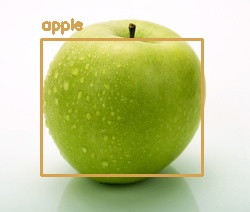

Image processed: clock.jpg

Detected object: clock with confidence level of 0.9683184623718262



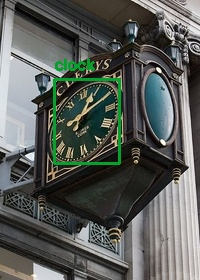

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185590624809265

Detected object: orange with confidence level of 0.5561691522598267



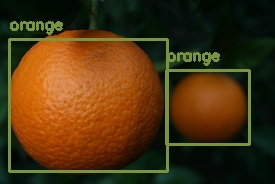

Image processed: car.jpg

Detected object: car with confidence level of 0.6325409412384033



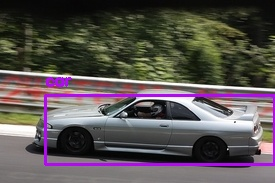

In [14]:
for image_file in image_files:
    detect_and_draw_box(image_file)

In [15]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [16]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [17]:
app = FastAPI(title='YoloC3 Application')

class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


@app.get("/")
def home():
    return "Go to documents http://localhost:8000/docs."



@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    
    image_stream = io.BytesIO(file.file.read())
    image_stream.seek(0)    
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    output_image = draw_bbox(image, bbox, label, conf)
    
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    return StreamingResponse(file_image, media_type="image/jpeg")

In [ ]:
nest_asyncio.apply()

host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"

uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [59]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:53032 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:53362 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
